# Simple RNN

In [1]:
import os
import sys
import glob
sys.path.append('..') #Adding the parent folder to import files from there

In [2]:
import src.loader as loader
import src.models.ngram as ngram
from ipywidgets import FloatProgress

/home/phong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Loading dataset (as in the `ngram` notebook)

In [3]:
source = [
    ('firstname', 'firstnames.firstname', 100),
    
    ('name', 'names.name', 100),
    
    ('code', 'patients.gender', 10),
    ('code', 'admissions.marital_status', 10),
    ('code', 'admissions.religion', 10),
    ('code', 'admissions.insurance', 10),
    ('code', 'admissions.admission_location', 10),
    ('code', 'prescriptions.drug_type', 30),
    ('code', 'prescriptions.dose_unit_rx', 20),
    
    ('date', 'prescriptions.startdate', 90),
    ('date', 'admissions.admittime', 10),
    
    ('id', 'admissions.hadm_id', 10),
    ('id', 'admissions.subject_id', 10),
    ('id', 'prescriptions.subject_id', 80),
    
    ('address', 'addresses.road', 100),
    
    ('city', 'addresses.city', 100)
]

In [4]:
dataset = []
labels = []
for column in source:
    if len(column) >= 3:
        label, column_name, nb_datasets = column
    else:
        label, column_name, nb_datasets = column, 1
    dataset.append((column_name, nb_datasets))
    labels += [label.upper()] * nb_datasets

In [5]:
%%time

max_value = len(labels)
bar = FloatProgress(min=0, max=max_value)
display(bar)

columns = loader.fetch_columns(dataset, dataset_size=100, load_bar=bar)

FloatProgress(value=0.0, max=700.0)

CPU times: user 941 ms, sys: 70.3 ms, total: 1.01 s
Wall time: 1.92 s


In [6]:
# Building a dictionary with the {label: [samples]} format (empty for now)
category_lines = {}
for i, label in enumerate(labels):
    category_lines[label] = []

In [7]:
import unicodedata
import string

all_letters = string.ascii_lowercase + string.punctuation + string.digits + string.whitespace
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [8]:
# Populating the data dictionary
for i, label in enumerate(labels):
    category_lines[label] += list(filter(None, [unicodeToAscii(x.lower()) for x in columns[i][1]]))

In [9]:
max_seq_lengths = []
for i, label in enumerate(labels):
    max_seq_lengths.append(max([len(x) for x in category_lines[label]]))

In [10]:
all_categories = list(category_lines.keys())
n_categories = len(all_categories)
max_length = max(max_seq_lengths)

In [11]:
print(category_lines['FIRSTNAME'][:5])
print(category_lines['NAME'][:5])
print(category_lines['ID'][:5])
print(category_lines['ADDRESS'][:5])

['leia', 'edouard', 'khira', 'prudent', 'adelia']
['staat', 'joubier', 'albinet', 'leveille', 'roziere']
['110958', '110958', '179418', '149469', '151798']
['rue du mont vallier', 'allee du docteur fernand lalesque', 'rue des charmes', 'route du moulin', 'residence les cigales']


In [12]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    conv = unicodeToAscii(line.lower())
    tensor = torch.zeros(len(conv), 1, n_letters)
    for li, letter in enumerate(conv):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lineToTensor('ALOÏS'))
print(lineToTensor('ALOÏS').size())

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

## Building a simple RNN

In [34]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2n = nn.Linear(input_size + hidden_size, hidden_size)
        self.n2n = nn.Linear(hidden_size, hidden_size)
        self.n2o = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2n(combined)
        output = self.n2n(output)
        output = self.n2o(output)
        output = self.activation(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [35]:
input = lineToTensor('vitali')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-1.9693, -1.9222, -1.9788, -1.9447, -1.9015, -1.9120, -1.9968]],
       grad_fn=<LogSoftmaxBackward>)


In [36]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('ID', 4)


In [37]:
# Random training samples generator
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = CITY / line = seyssinet-pariset
category = CITY / line = decines-charpieu
category = ADDRESS / line = rue de verdun
category = NAME / line = jaget
category = NAME / line = lorca
category = CODE / line = protestant quaker
category = CODE / line = emergency room admit
category = ADDRESS / line = rue des lilas
category = ADDRESS / line = rue de la genevraie
category = CITY / line = igon


## Training the model

In [38]:
# Choosing a loss function (here NLL, matching with the Softmax layer of our RNN)
criterion = nn.NLLLoss()

In [39]:
learning_rate = 0.002 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [40]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 500



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 1.7622 rue de chantemerle / ADDRESS ✓
10000 10% (0m 22s) 0.0006 2192-04-17t00:00:00 / DATE ✓
15000 15% (0m 33s) 1.2085 marcet / NAME ✓
20000 20% (0m 55s) 0.0054 impasse des aubepines / ADDRESS ✓
25000 25% (1m 16s) 3.4462 not specified / ADDRESS ✗ (CODE)
30000 30% (1m 36s) 0.0650 main / CODE ✓
35000 35% (1m 49s) 0.0022 chemin de la lande / ADDRESS ✓
40000 40% (2m 3s) 0.7120 echavanne / CITY ✓
45000 45% (2m 22s) 0.0001 10083 / ID ✓
50000 50% (2m 38s) 1.4167 blayo / FIRSTNAME ✗ (NAME)
55000 55% (2m 54s) 0.0000 2130-02-06t00:00:00 / DATE ✓
60000 60% (3m 9s) 0.0000 2138-04-10t00:00:00 / DATE ✓
65000 65% (3m 22s) 0.7047 malbrun / NAME ✓
70000 70% (3m 34s) 1.0029 villers-sur-fere / ADDRESS ✗ (CITY)
75000 75% (3m 47s) 0.0001 10119 / ID ✓
80000 80% (4m 0s) 0.0000 2115-05-13t00:00:00 / DATE ✓
85000 85% (4m 13s) 0.0207 151798 / ID ✓
90000 90% (4m 32s) 0.0002 10027 / ID ✓
95000 95% (5m 1s) 0.2163 rue jehan fouquet / ADDRESS ✓
100000 100% (5m 25s) 0.0178 main / CODE ✓


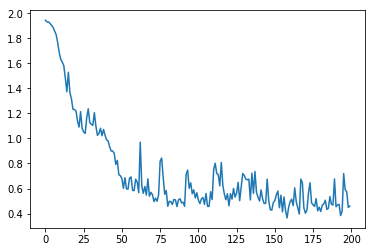

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses);

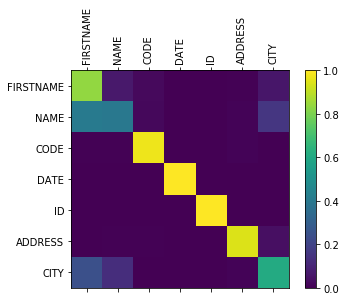

In [42]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


plt.show()

In [74]:
def predict(input_line, n_predictions=3, verbose=True):
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        if verbose:
            print('\n> %s' % input_line)
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            if verbose:
                print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
            
    return predictions

# Top 3 catégories prédites
predict('Rue Léo Delibes')
predict('Paul')
predict('Cachan')
predict('17389')
predict('2123-09-01t00:00:00')


> Rue Léo Delibes
(-0.03) ADDRESS
(-3.65) CITY
(-7.69) NAME

> Paul
(-1.04) NAME
(-1.52) FIRSTNAME
(-1.61) ADDRESS

> Cachan
(-0.44) FIRSTNAME
(-1.62) NAME
(-1.94) CITY

> 17389
(-0.06) ID
(-3.10) FIRSTNAME
(-5.18) DATE

> 2123-09-01t00:00:00
(-0.00) DATE
(-13.30) ID
(-15.13) FIRSTNAME


[[-1.9073486328125e-06, 'DATE'],
 [-13.301948547363281, 'ID'],
 [-15.130189895629883, 'FIRSTNAME']]

## Columnar classification

In [144]:
from statistics import mode

def predict_column(column_nb, sampling):
    column = columns[column_nb]
    sample_length = int(sampling * len(column[1]))
    sample_prediction = []
    for i in range(sample_length):
        try:
            sample_prediction.append(predict(randomChoice(column[1]), n_predictions=1, verbose=False)[0][1])
        except UnboundLocalError:
            sample_prediction.append('UNKNOWN')
    return labels[column_nb], max(sample_prediction, key=sample_prediction.count)

In [145]:
truth, prediction = predict_column(699, 1)
print("Predicted column category = " + prediction + ", True column category = " + truth)

Predicted column category = CITY, True column category = CITY


In [148]:
right = 0
predictions = []
for i in range(len(columns)):
    truth, prediction = predict_column(i, 0.50)
    if truth == prediction:
        right += 1
print("Accuracy = ", right/len(columns))

Accuracy =  0.9328571428571428
